In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('soft/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [2]:
# Load bitstream with custom overlay
soc = QickTrainingSoc('./qick_training.bit')
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU208

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [4]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

In [5]:
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1)
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1)
        
        # First DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][0], gen_ch=self.cfg['gen_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][0], 
                                     length = self.us2cycles(self.cfg['pulse_length'][0],gen_ch=self.cfg['gen_ch'][0]))
        
        # Second DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][1], gen_ch=self.cfg['gen_ch'][1])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][1], 
                                     length = self.us2cycles(self.cfg['pulse_length'][1],gen_ch=self.cfg['gen_ch'][1]))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0], phase=0, phrst=0, mode="oneshot")
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1], phase=0, phrst=0, mode="oneshot")        
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.pulse(ch     = self.cfg['gen_ch'][1],
                   t      = self.us2cycles(self.cfg['pulse_start'][1], gen_ch = self.cfg['gen_ch'][1]))
        
        self.measure(pulse_ch        = self.cfg['gen_ch'][0], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [4],
        "ro_length"   : 20,
        "ro_freq"     : 500,
        "ro_offset"   : 0.2,
        
        "gen_ch"      : [4,0],        
        "pulse_length": [10,10],
        "pulse_start" : [0,0],
        "pulse_gain"  : [1000,1000], # [DAC units]
        "pulse_freq"  : [501,501], # [MHz]
        
        "reps"        : 1,
        "period"      : 20
       }

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

  0%|          | 0/1 [00:00<?, ?it/s]

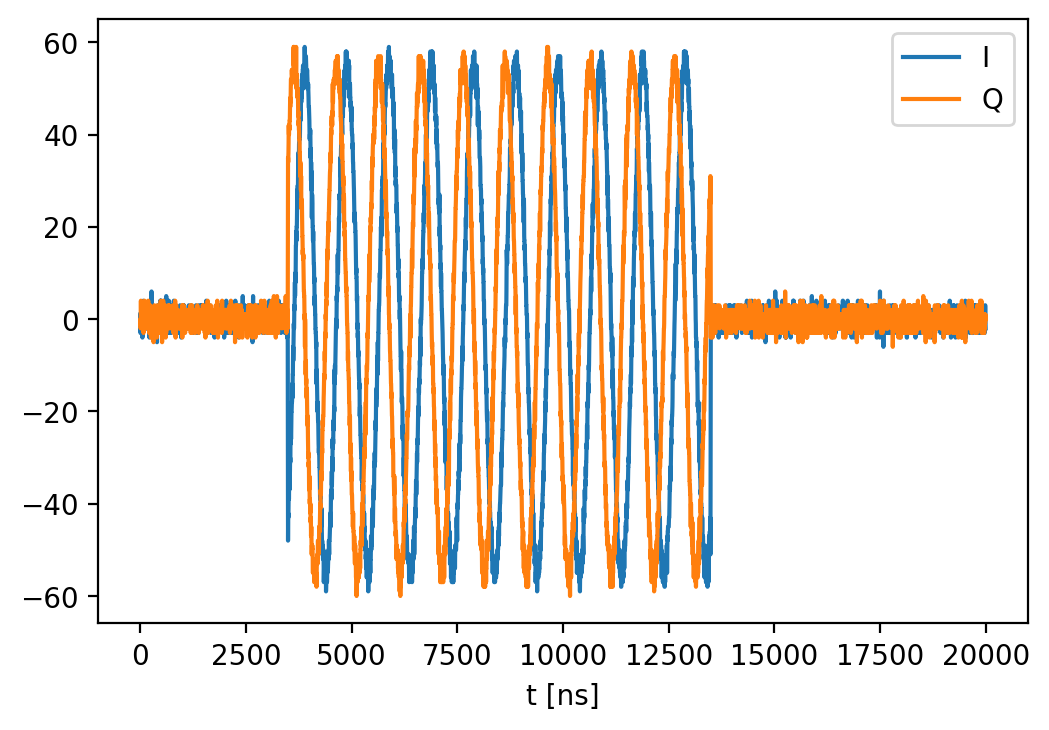

In [6]:
# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  

In [ ]:
class ReadoutMultiTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1)
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1)
        
        # First DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][0], gen_ch=self.cfg['gen_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][0], 
                                     length = self.us2cycles(self.cfg['pulse_length'][0],gen_ch=self.cfg['gen_ch'][0]))
        
        # Second DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][1], gen_ch=self.cfg['gen_ch'][1])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][1], 
                                     length = self.us2cycles(self.cfg['pulse_length'][1],gen_ch=self.cfg['gen_ch'][1]))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'][0])
        
        self.declare_readout(ch      = self.cfg['ro_ch'][1], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][1]),
                             freq    = self.cfg['ro_freq'][1])        
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0], phase=0, phrst=0, mode="oneshot")
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1], phase=0, phrst=0, mode="oneshot")        
        
        self.synci(200)  # give processor some time to configure pulses        
    
    def body(self):               
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [4,5],
        "ro_length"   : 2,
        "ro_freq"     : [220,1110],
        "ro_offset"   : 0.3,
        
        "gen_ch"      : [4,0],        
        "pulse_length": [12,16],
        "pulse_start" : [0,0],
        "pulse_gain"  : [30000,20000], # [DAC units]
        "pulse_freq"  : [220,500], # [MHz]
        
        "reps"        : 1,
        "period"      : 20
       }

prog = ReadoutMultiTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

In [ ]:
# Plot Captured Data.

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

x = ts*np.arange(len(iq_list[0][0]))

# Channel 0.
yi = iq_list[0][0]
yq = iq_list[0][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 0');
plt.legend(['I','Q']);

# Channel 1.
yi = iq_list[1][0]
yq = iq_list[1][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 1');
plt.legend(['I','Q']);